# Code for Lending Club Data Analysis
## Fall 2019 CS156
## Yuhao Chen

### 1. Import necessary libraries

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
import numpy as np

### 2. Load datasets

In [13]:
approve_set = pd.read_csv('ApproveStats.csv', skiprows = 1, low_memory=False)
reject_set = pd.read_csv('RejectStats.csv', skiprows = 1, low_memory=False)
# print("Length of Approve Set:",len(approve_set))
# print("Length of Reject Set:",len(reject_set))
# print("Number of Column in Reject Set:",len(reject_set.columns.values.tolist()))
# print("Number of Column in Approve Set:",len(approve_set.columns.values.tolist()))
# print(reject_set.head)
# print(approve_set.head)

### 3. Combine two datasets

In [14]:
approve_set = approve_set[['loan_amnt', 'dti', 'addr_state', 'emp_length']]
approve_set['approve_state'] = 1
approve_set['dti'] = approve_set['dti']/100


def del_sign(x):
    return float(x[0:-1])/100

reject_set = reject_set[['Amount Requested', 'Debt-To-Income Ratio', 'State', 'Employment Length']].tail(42538)
reject_set.columns = ['loan_amnt', 'dti', 'addr_state', 'emp_length']
reject_set['approve_state'] = 0
reject_set['dti'] = reject_set['dti'].apply(del_sign)

combined_set = pd.concat([approve_set, reject_set], axis=0)
combined_set.index = range(0,len(combined_set))

# print(approve_set)
# print(reject_set)
# print(combined_set)
# print(type(approve_set))
# print(type(reject_set))

### 4. Deal with missing data

In [15]:
# print(combined_set.dtypes.value_counts())
# print(combined_set.isnull().sum().sort_values(ascending=False))
# print(combined_set[combined_set[['addr_state','dti','loan_amnt']].isnull().T.any()])

combined_set = combined_set.drop([39786, 42536, 42537])

# print(combined_set[combined_set[['emp_length']].isnull().T.any()])

combined_set['emp_length'] = combined_set['emp_length'].fillna('Unknown')

# print(combined_set.isnull().sum().sort_values(ascending=False))

### 5. Feature abstraction

In [16]:
mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0,
        "Unknown": 5
    }
}

combined_set = combined_set.replace(mapping_dict)
# print(combined_set.head())

dummy_set = pd.get_dummies(combined_set['addr_state'])
combined_set = pd.concat([combined_set, dummy_set], axis=1)
combined_set = combined_set.drop(['addr_state'], axis=1)

# print(combined_set.info())
# print(combined_set.head())

### 6. Create two datasets(one for MinMaxScaler model and one for StandardScaler model)

In [17]:
col = combined_set.columns.drop('approve_state')
combined_set_ml1 = combined_set
combined_set_ml2 = combined_set

sc1 = StandardScaler()
combined_set_ml1[col] =sc1.fit_transform(combined_set_ml1[col])
# print(combined_set_ml.head())
X1 = combined_set_ml1[col]
y1 = combined_set_ml1['approve_state']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=75)


sc2 = MinMaxScaler(feature_range=(0, 1))
combined_set_ml2[col] =sc2.fit_transform(combined_set_ml2[col])
X2 = combined_set_ml2[col]
y2 = combined_set_ml2['approve_state']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=75)

### 7. Cross-Validation to understand the better model

In [18]:
kf = KFold(n_splits=10, random_state=75)
score1 = []
score2 = []
for train_index, valid_index in kf.split(X1_train):
    X1_trainset, y1_trainset = X1_train.iloc[train_index], y1_train.iloc[train_index]
    X1_validset, y1_validset = X1_train.iloc[valid_index], y1_train.iloc[valid_index]
    X2_trainset, y2_trainset = X2_train.iloc[train_index], y2_train.iloc[train_index]
    X2_validset, y2_validset = X2_train.iloc[valid_index], y2_train.iloc[valid_index]

    lr1 = LogisticRegression()
    lr1.fit(X1_trainset, y1_trainset)
    predicted1 = lr1.predict(X1_validset)
    score1.append(accuracy_score(predicted1, y1_validset))

    lr2 = LogisticRegression()
    lr2.fit(X2_trainset, y2_trainset)
    predicted2 = lr2.predict(X2_validset)
    score2.append(accuracy_score(predicted2, y2_validset))

print("Score for Stardard Scaler Model:", np.mean(score1))
print("Score for MinMax Scaler Model:", np.mean(score2))

Score for Stardard Scaler Model: 0.8192305736046992
Score for MinMax Scaler Model: 0.8172658578244377


### 8. Train model on whole training set and test on test set

In [22]:
lr1 = LogisticRegression()
lr1.fit(X1_train, y1_train)

predict1_1 = lr1.predict(X1_test)
print('Accuacy on the testing set is:', accuracy_score(predict1_1, y1_test))
predict1_2 = lr1.predict(X1_train)
print('Accuacy on the training set is:', accuracy_score(predict1_2, y1_train))

Accuacy on the testing set is: 0.8215265261343155
Accuacy on the training set is: 0.8198518916558916


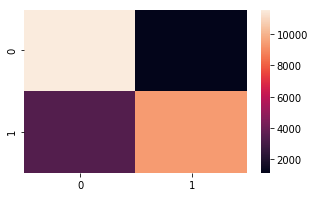

In [27]:
# Print the results on confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
m = confusion_matrix(y1_test, predict1_1) 
plt.figure(figsize=(5,3))
sns.heatmap(m)
plt.show()